## Inpatient_admission preprocessing and EDA

#### Preprocessing includes:

1. Add a binary column *Cardiovascular*: {0: patient has no Cardiovascular diagnosis, 1: patient has Cardiovascular diagnosis}

2. Add a binary column *Readmission*: {0: patient has no readmission records, 1: patient has readmission records}

3. Clean the outpatientflag column: {0: patient is not in the outpatient table, 1: patient is in the outpatient table}

4. Combine categories in Admitting unit service: {Combine REHAB MEDICINE and INTERMEDIATE MED to MEDICINE, 
Combine (Censored), Not specified (no value), Not specified, NON-COUNT, BLIND REHAB, SPINAL CORD INJURY, DOMICILIARY, NEUROLOGY to OTHERS}
// TODO: Need better ways to combine

#### EDA includes:

Correltation between *target* in ['Died during admission', 'Readmission'] and *variable* in ['Discharge disposition', 'Admitting unit service', 'Agentorangeflag', 'Serviceconnectedflag'].



In [3]:
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_PATH = "VCHAMPS"

In [ ]:
# dataset
# useful column: Internalpatientid, Age at admission, Admission date, 
#                First listed discharge diagnosis icd10 subcategory, Second listed discharge diagnosis icd10 subcategory,
#                Died during admission, Outpatientreferralflag
dataset_path = 'inpatient_admissions_train.csv'
load_path = os.path.join(DATA_PATH, dataset_path)
in_ad = pd.read_csv(load_path,index_col=0)
in_ad

In [ ]:
# dataset
dataset_path = 'outpatient_visits_train.csv'
load_path = os.path.join(DATA_PATH, dataset_path)
out_visits = pd.read_csv(load_path)
out_visits = out_visits[["Internalpatientid", "Age at visit", "First listed diagnosis icd10 subcategory", "Second listed diagnosis icd10 subcategory"]]
out_visits

,Internalpatientid,Age at visit,First listed diagnosis icd10 subcategory,Second listed diagnosis icd10 subcategory
0,1,60.619995,Not specified,Not specified
1,1,61.032110,Not specified,Not specified
2,1,61.907075,Not specified,Not specified
3,1,62.296573,Not specified,Not specified
4,1,63.632066,Not specified,Not specified
...,...,...,...,...
82692715,99999,96.300251,Not specified,Not specified
82692716,99999,96.322523,Not specified,Not specified
82692717,99999,96.327503,Not specified,Not specified
82692718,99999,96.360092,Not specified,Not specified


In [ ]:
cardiovascular = ["Heart failure, unspecified", "Other heart failure",
                  "Cardiogenic shock", "Hypertensive heart disease with heart failure",
                  "Hypertensive heart and kidney disease with heart failure", "Unstable angina", "Other forms of chronic ischemic heart disease",
                  "Atherosclerotic heart disease of native coronary artery", "Atrial fibrillation", "Atrial flutter",
                  "Supraventricular tachycardia", "Ventricular tachycardia"]
# "Systolic (congestive) heart failure", "Diastolic (congestive) heart failure", "Combined systolic (congestive) and diastolic (congestive) heart failure",
# "ST elevation (STEMI) myocardial infarction", "Non-ST elevation (NSTEMI) myocardial infarction"

In [ ]:
# Find all patients that have diagnosed as cardiovascular
cardio_in = in_ad[in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | in_ad["Second listed discharge diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains('|'.join(cardiovascular))
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Systolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Diastolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Combined systolic (congestive) and diastolic (congestive) heart failure", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("ST elevation (STEMI) myocardial infarction", regex=False)
      | in_ad["First listed discharge diagnosis icd10 subcategory"].str.contains("Non-ST elevation (NSTEMI) myocardial infarction", regex=False)]["Internalpatientid"].unique()


In [ ]:
# Find all the patients who has cardiovascular
# cardio_all = np.union1d(np.union1d(cardio_in, cardio_out), cardio_ed)
# len(cardio_all)

In [ ]:
# all_patients = np.union1d(np.union1d(in_ad["Internalpatientid"].unique(), ed["Internalpatientid"].unique()), out_visits["Internalpatientid"].unique())
# noncardio_all = np.setdiff1d(all_patients, cardio_all)
# len(noncardio_all)

In [ ]:
# save the patients
# np.save("cardio_all.npy", cardio_all)
# np.save("noncardio_all.npy", noncardio_all)
# np.save("all_patient.npy", all_patients)

-----
Add new columns to the inpatient_admission table

In [ ]:
out_patientid = out_visits['Internalpatientid'].unique()

In [ ]:
readmission_id = []
for ids, group in tqdm(in_ad.groupby("Internalpatientid")):
    pid = group["Internalpatientid"].unique()[0]
    num_admissions = group["Age at admission"].nunique()
    if num_admissions > 1: readmission_id.append(pid)

  0%|          | 0/84536 [00:00<?, ?it/s]

In [ ]:
cardio = []
readmission = []
outpatient = []
for row in in_ad['Internalpatientid']:
    if row in readmission_id: readmission.append(1)
    else: readmission.append(0)
     
    if row in cardio_in: cardio.append(1)
    else: cardio.append(0)

    if row in out_patientid: outpatient.append(1)
    else: outpatient.append(0)

    

In [ ]:
in_ad["Cardiovascular"] = cardio
in_ad["Readmission"] = readmission
in_ad["Outpatientreferralflag"] = outpatient

In [ ]:
in_ad["Died during admission"] = in_ad["Died during admission"].replace({"No":0, "Yes": 1})
in_ad["Serviceconnectedflag"] = in_ad["Serviceconnectedflag"].replace({"No":0, "Yes": 1})
in_ad["Agentorangeflag"] = in_ad["Agentorangeflag"].replace({"No":0, "Yes": 1})
in_ad

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,Discharge disposition,Died during admission,Outpatientreferralflag,Serviceconnectedflag,Agentorangeflag,State,Cardiovascular,Readmission
0,10,65.649075,2015-11-28 17:41:09.0,2015-11-29 01:43:14.0,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,"Pneumonia, unspecified organism",Hypokalemia,Regular,0,1,NaN,1.0,Utah,0,0
1,100001,83.767138,2009-10-01 21:19:50.0,2009-10-04 16:51:33.0,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Essential (primary) hypertension,Regular,0,1,0.0,0.0,North Carolina,0,1
2,100001,84.873295,2010-11-10 04:32:39.0,2010-11-19 08:49:45.0,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,"Osteoarthritis, unspecified site",Type 2 diabetes mellitus with neurological com...,Regular,0,1,NaN,0.0,North Carolina,0,1
3,10001,70.900369,2020-03-20 02:02:26.0,2020-03-28 08:47:01.0,SURGERY,SURGERY,PLASTIC SURGERY,SURGICAL STEPDOWN,Nonrheumatic mitral (valve) prolapse,Postprocedural shock,Regular,0,1,NaN,1.0,Florida,0,0
5,100016,83.054993,1999-11-20 14:23:45.0,1999-12-01 03:57:43.0,MEDICINE,MEDICINE,HEMATOLOGY/ONCOLOGY,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Unspecified mental disorder due to known physi...,Regular,0,1,NaN,NaN,Idaho,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665831,99965,93.433950,2022-07-21 02:36:19.0,2022-08-01 14:55:43.0,MEDICINE,MEDICINE,SUBST ABUSE CWT/TRANS RESID,GENERAL(ACUTE MEDICINE),Chronic or unspecified duodenal ulcer with hem...,Diastolic (congestive) heart failure,Regular,0,1,NaN,0.0,California,1,1
665832,99975,86.145532,2015-08-08 04:36:10.0,2015-08-17 03:26:06.0,MEDICINE,MEDICINE,Not specified,GENERAL(ACUTE MEDICINE),"Cutaneous abscess, furuncle and carbuncle of l...","Finding of other specified substances, not nor...",Regular,0,1,NaN,0.0,Minnesota,0,1
665833,99975,88.555516,2018-01-05 00:59:05.0,2018-01-06 23:18:39.0,NON-COUNT,NON-COUNT,PODIATRY,MEDICAL OBSERVATION,"Umbilical hernia with obstruction, without gan...",Essential (primary) hypertension,Regular,0,1,NaN,0.0,Minnesota,0,1
665834,99986,73.435908,2019-06-26 19:47:10.0,2019-06-29 21:18:00.0,MEDICINE,MEDICINE,INTERMEDIATE MEDICINE,GENERAL(ACUTE MEDICINE),Cellulitis and acute lymphangitis of other par...,Other chronic osteomyelitis,Regular,0,1,NaN,0.0,Nevada,1,1


In [ ]:
in_ad.to_csv("inpatient_admission_withtarget.csv")

### Data Cleaning

In [6]:
in_ad = pd.read_csv("inpatient_admission_withtarget.csv", index_col=0)

#### Admitting unit service

Combined admitting unit service and change it to one-hot decoding format

Question: How to impute those missing values?

In [7]:
in_ad[in_ad["Age at admission"].isnull() | in_ad["Admission date"].isnull()]

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,Discharge disposition,Died during admission,Outpatientreferralflag,Serviceconnectedflag,Agentorangeflag,State,Cardiovascular,Readmission


In [8]:
# Combine groups with smaller counts into one category
in_ad["Admitting unit service"] = in_ad["Admitting unit service"].replace({'REHAB MEDICINE':'MEDICINE', 'INTERMEDIATE MED':'MEDICINE',
                                        '(Censored)':'OTHERS', 'Not specified (no value)':'OTHERS', 'Not specified':'OTHERS', 'NON-COUNT':'OTHERS',
                                        'BLIND REHAB':'OTHERS', 'SPINAL CORD INJURY':'OTHERS', 'DOMICILIARY':'OTHERS', 'NEUROLOGY':'OTHERS'})

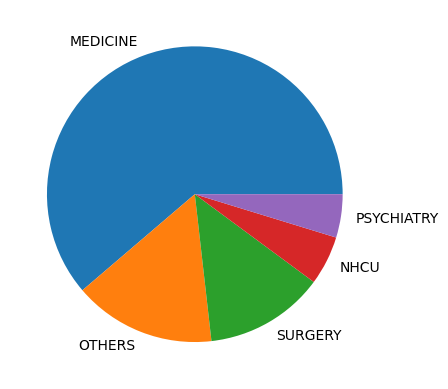

In [9]:
plt.pie(in_ad["Admitting unit service"].value_counts(), labels = in_ad["Admitting unit service"].value_counts().index);

In [10]:
in_ad[['Admitting unit service', 'Died during admission']].groupby('Admitting unit service', as_index=False).mean()

,Admitting unit service,Died during admission
0,MEDICINE,0.027475
1,NHCU,0.223150
2,OTHERS,0.002511
3,PSYCHIATRY,0.001373
4,SURGERY,0.015821


In [11]:
in_ad[['Admitting unit service', 'Readmission']].groupby('Admitting unit service', as_index=False).mean()


,Admitting unit service,Readmission
0,MEDICINE,0.967763
1,NHCU,0.968218
2,OTHERS,0.975320
3,PSYCHIATRY,0.982351
4,SURGERY,0.963226


<Axes: xlabel='Admitting unit service', ylabel='Died during admission'>

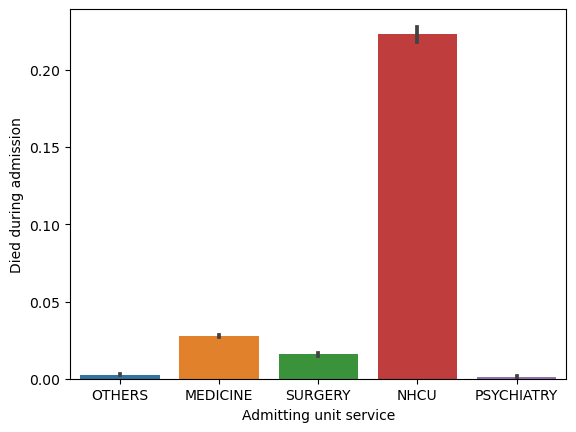

In [12]:
sns.barplot(x = 'Admitting unit service', y = 'Died during admission', data=in_ad)

<Axes: xlabel='Admitting unit service', ylabel='Readmission'>

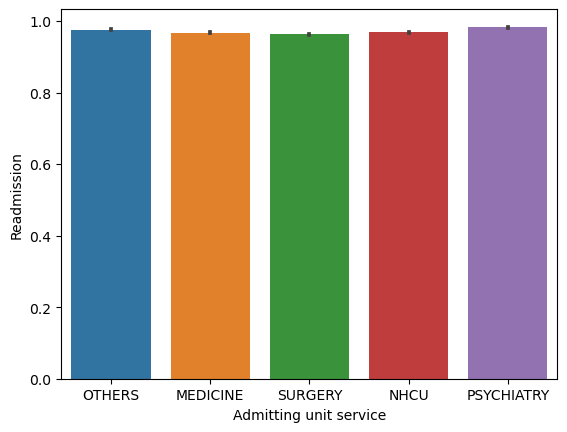

In [13]:
sns.barplot(x = 'Admitting unit service', y = 'Readmission', data=in_ad)

#### Age

age is right skewed and could be treated as continuous variable

(array([   447.,   2170.,  12770.,  54825., 121942., 142419., 113438.,
         62669.,  11663.,    397.]),
 array([ 20.39913282,  29.28171229,  38.16429176,  47.04687123,
         55.9294507 ,  64.81203017,  73.69460964,  82.57718911,
         91.45976858, 100.34234805, 109.22492752]),
 <BarContainer object of 10 artists>)

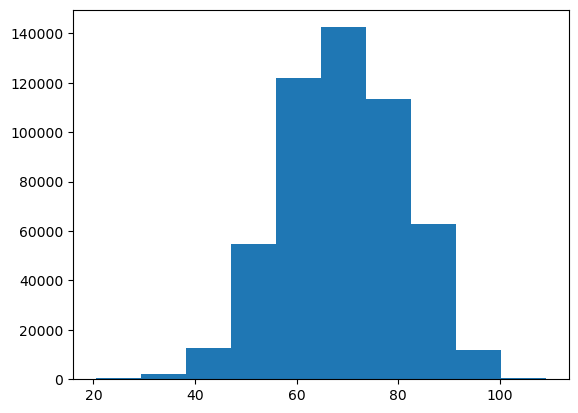

In [14]:
plt.hist(in_ad["Age at admission"])

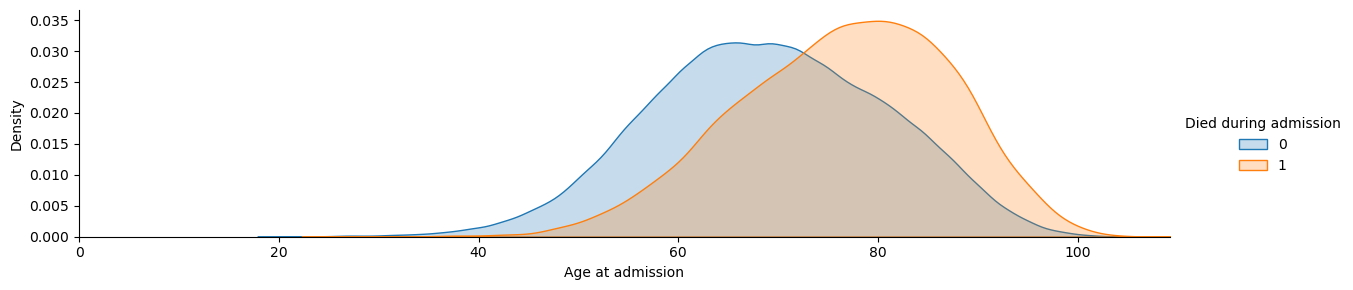

In [15]:
a = sns.FacetGrid(in_ad, hue = "Died during admission", aspect=4)
a.map(sns.kdeplot, 'Age at admission', fill= True )
a.set(xlim=(0 , in_ad['Age at admission'].max()))
a.add_legend()

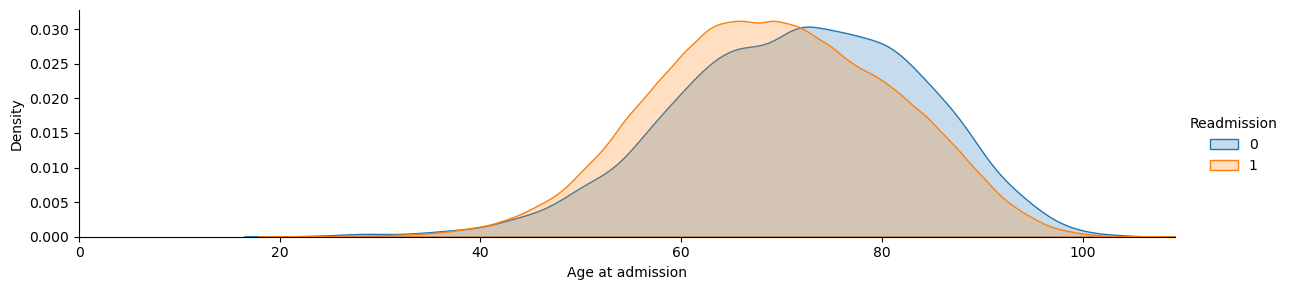

In [16]:
a = sns.FacetGrid(in_ad, hue = "Readmission", aspect=4)
a.map(sns.kdeplot, 'Age at admission', fill= True )
a.set(xlim=(0 , in_ad['Age at admission'].max()))
a.add_legend()

age definitely has strong impact on both readmission and mortality

#### Admitting specialty

Need further combination

In [17]:
in_ad["Admitting specialty"].nunique()

124

#### Discharge disposition

Change to one-hot decoding

In [18]:
in_ad["Discharge disposition"].unique()

array(['Regular', 'NBC or while ASIH', 'Death without autopsy',
       'Transfer', 'Irregular', 'Not specified (no value)',
       'Death with autopsy'], dtype=object)

In [19]:
in_ad[['Discharge disposition', 'Died during admission']].groupby('Discharge disposition', as_index=False).mean()

,Discharge disposition,Died during admission
0,Death with autopsy,0.940063
1,Death without autopsy,0.957836
2,Irregular,0.000303
3,NBC or while ASIH,0.334802
4,Not specified (no value),0.000000
5,Regular,0.001060
6,Transfer,0.002398


In [20]:
in_ad[['Discharge disposition', 'Readmission']].groupby('Discharge disposition', as_index=False).mean()

,Discharge disposition,Readmission
0,Death with autopsy,0.842271
1,Death without autopsy,0.890306
2,Irregular,0.971371
3,NBC or while ASIH,1.000000
4,Not specified (no value),0.965726
5,Regular,0.971370
6,Transfer,0.975852


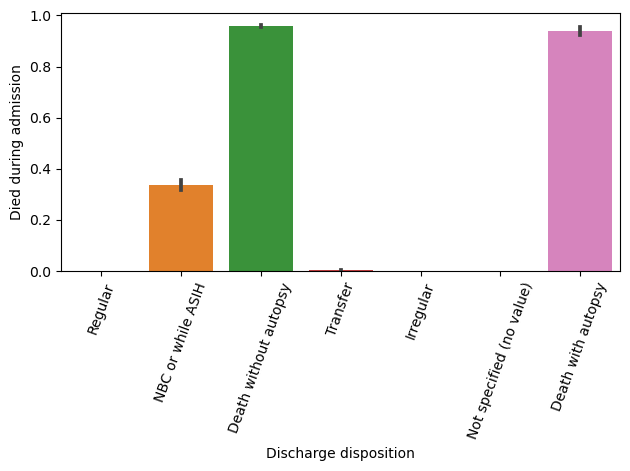

In [21]:
sns.barplot(x = 'Discharge disposition', y = 'Died during admission', data=in_ad)
plt.xticks(rotation=70)
plt.tight_layout()

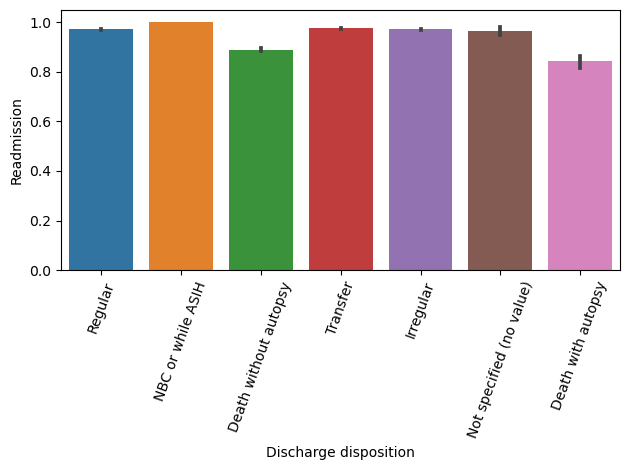

In [22]:
sns.barplot(x = 'Discharge disposition', y = 'Readmission', data=in_ad)
plt.xticks(rotation=70)
plt.tight_layout()

Note: This category can't be treated as one feature since it's clearly indicated the death

Only NBC or while ASIH might have impact on mortality

#### State

In [23]:
in_ad["State"].nunique()

50

#### Serviceconnectedflag

<Axes: xlabel='Serviceconnectedflag', ylabel='Died during admission'>

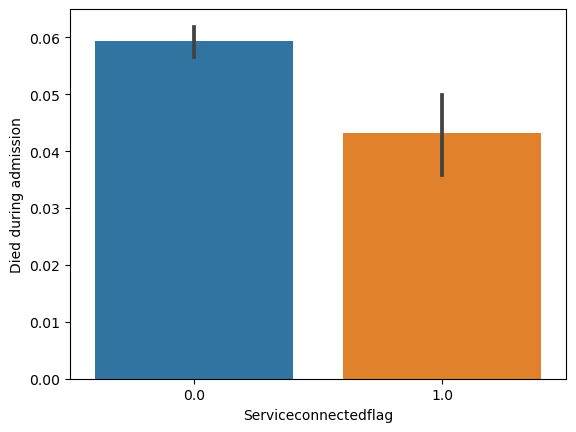

In [24]:
sns.barplot(x = 'Serviceconnectedflag', y = 'Died during admission', data=in_ad)

<Axes: xlabel='Serviceconnectedflag', ylabel='Readmission'>

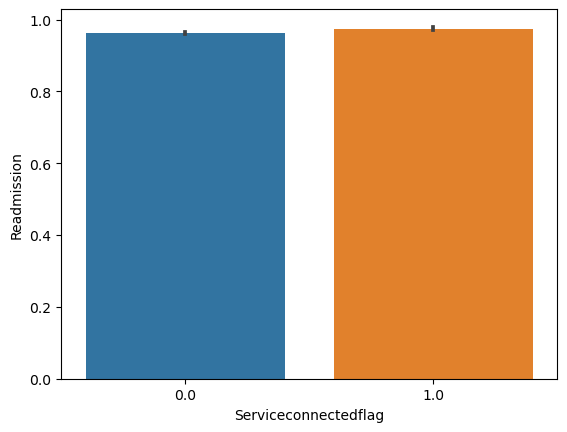

In [25]:
sns.barplot(x = 'Serviceconnectedflag', y = 'Readmission', data=in_ad)

#### Agentorangeflag

<Axes: xlabel='Agentorangeflag', ylabel='Died during admission'>

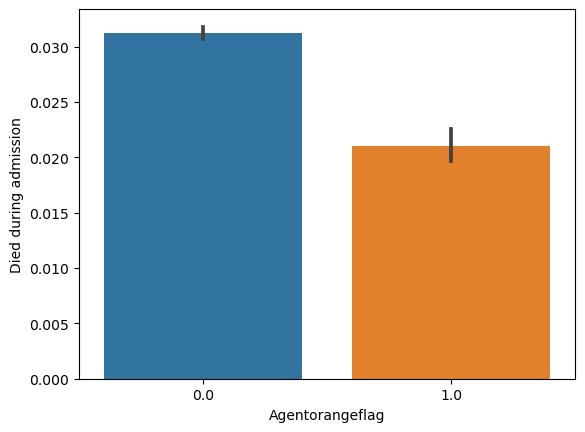

In [26]:
sns.barplot(x = 'Agentorangeflag', y = 'Died during admission', data=in_ad)

<Axes: xlabel='Agentorangeflag', ylabel='Readmission'>

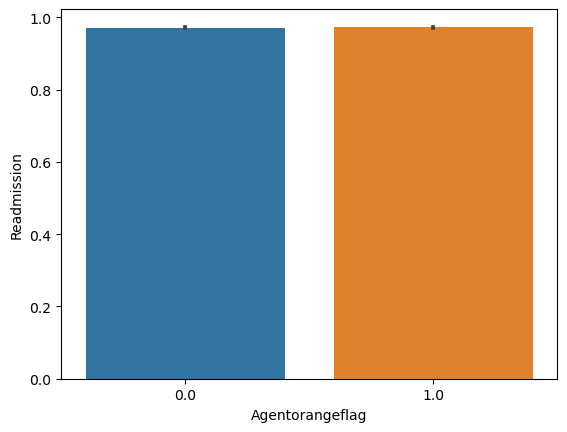

In [27]:
sns.barplot(x = 'Agentorangeflag', y = 'Readmission', data=in_ad)

#### Find Correlations

In [28]:
# importing the required function
from scipy.stats import chi2_contingency

In [29]:
for target in ['Died during admission', 'Readmission']:
    for variable in ['Discharge disposition', 'Admitting unit service', 'Agentorangeflag', 'Serviceconnectedflag']:
        # Cross tabulation between Discharge disposition and Mortality
        CrosstabResult=pd.crosstab(index=in_ad[variable],columns=in_ad[target])
        # print(CrosstabResult)
        
        # Performing Chi-sq test
        ChiSqResult = chi2_contingency(CrosstabResult)
        
        # P-Value is the Probability of H0 being True
        # # If P-Value > 0.05 then only we Accept the assumption(H0): They're NOT related
        print("For the correlation between", target, "and", variable) 
        print('The P-Value of the ChiSq Test is:', ChiSqResult[1], "\n")

For the correlation between Died during admission and Discharge disposition
The P-Value of the ChiSq Test is: 0.0 

For the correlation between Died during admission and Admitting unit service
The P-Value of the ChiSq Test is: 0.0 

For the correlation between Died during admission and Agentorangeflag
The P-Value of the ChiSq Test is: 7.732082821855652e-32 

For the correlation between Died during admission and Serviceconnectedflag
The P-Value of the ChiSq Test is: 0.0001353705178199909 

For the correlation between Readmission and Discharge disposition
The P-Value of the ChiSq Test is: 0.0 

For the correlation between Readmission and Admitting unit service
The P-Value of the ChiSq Test is: 4.08657576809294e-74 



For the correlation between Readmission and Agentorangeflag
The P-Value of the ChiSq Test is: 0.4239283789823749 

For the correlation between Readmission and Serviceconnectedflag
The P-Value of the ChiSq Test is: 0.00018626172956333 



In [30]:
in_ad['Admitting unit service'] = in_ad['Admitting unit service'].astype('category')
in_ad['Admitting unit service encoding'] = in_ad['Admitting unit service'].cat.codes

in_ad['Discharge disposition'] = in_ad['Discharge disposition'].astype('category')
in_ad['Discharge disposition encoding'] = in_ad['Discharge disposition'].cat.codes

<Axes: >

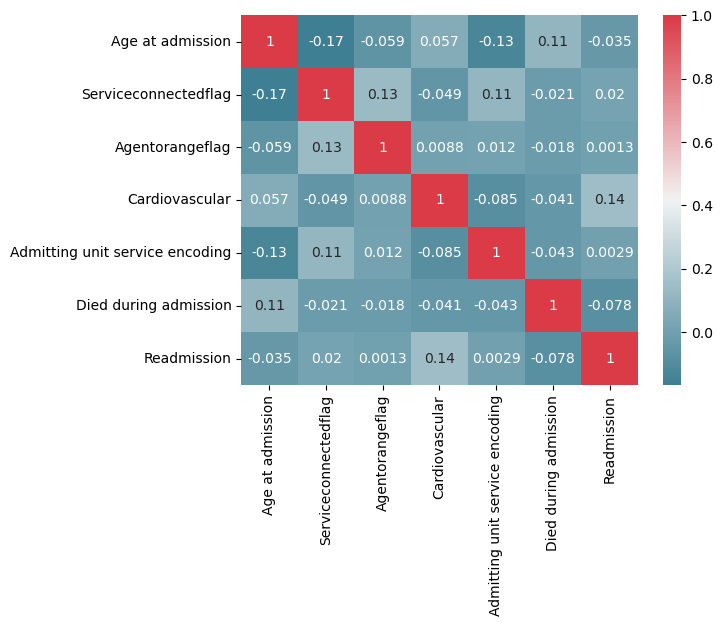

In [31]:
sns.heatmap(in_ad[["Age at admission", "Serviceconnectedflag", "Agentorangeflag", "Cardiovascular", 
                   "Admitting unit service encoding", "Died during admission", "Readmission"]].corr(), 
       cmap = sns.diverging_palette(220, 10, as_cmap = True),annot=True)

#### Convert to one-hot encoding

In [32]:
complete_ad = pd.concat([in_ad.drop(["Admitting unit service encoding", "Discharge disposition encoding"], axis=1), pd.get_dummies(in_ad['Admitting unit service'])], axis=1)

### Handling Imbalance 

**Undersampling**: It is the process where you randomly delete some of the observations from the majority class in order to match the numbers with the minority class.

**Oversampling**: It is the process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class.

Text(0.5, 1.0, 'Mortality target variable count')

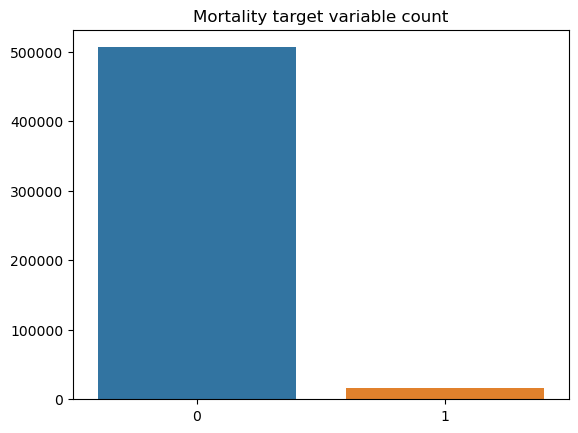

In [33]:
x=complete_ad["Died during admission"].value_counts().values
sns.barplot(x=[0,1],y=x)
plt.title('Mortality target variable count')

Text(0.5, 1.0, 'Readmission')

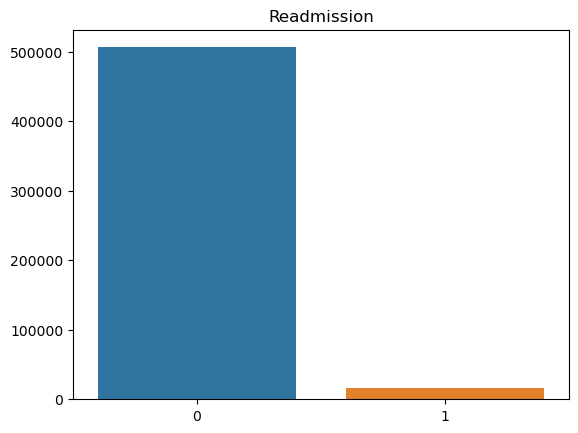

In [34]:
x=complete_ad["Readmission"].value_counts().values
sns.barplot(x=[0,1],y=x)
plt.title('Readmission')

In [35]:
not_readmitted=complete_ad[complete_ad.Readmission==0]
readmitted=complete_ad[complete_ad.Readmission==1]

In [36]:
from sklearn.utils import resample
#upsample minority
readmitted_upsampled = resample(readmitted,
                          replace=True, # sample with replacement
                          n_samples=len(not_readmitted), # match number in majority class
                          random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([not_readmitted, readmitted_upsampled])

# check new class counts
upsampled.Readmission.value_counts()

0    16174
1    16174
Name: Readmission, dtype: int64

### Handling Missing values (TODO)

In [37]:
for i in complete_ad.columns:
    print(i, complete_ad[complete_ad[i].isna()].shape[0])

Internalpatientid 0
Age at admission 0
Admission date 0
Discharge date 494
Admitting unit service 0
Discharging unit service 0
Admitting specialty 0
Discharging specialty 0
First listed discharge diagnosis icd10 subcategory 0
Second listed discharge diagnosis icd10 subcategory 0
Discharge disposition 0
Died during admission 0
Outpatientreferralflag 0
Serviceconnectedflag 487689
Agentorangeflag 104512
State 0
Cardiovascular 0
Readmission 0
MEDICINE 0
NHCU 0
OTHERS 0
PSYCHIATRY 0
SURGERY 0


We will mainly focus on Serviceconnectedflag and Agentorangeflag

### Feature Scaling 

In [38]:
from sklearn import preprocessing
scaled_X = preprocessing.StandardScaler().fit_transform(complete_ad[["Age at admission"]])

In [40]:
complete_ad["Age scaled"] = scaled_X

In [44]:
complete_ad.to_csv("inpatient_admission_complete.csv")